In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
sample_size = 465
width = 150
height = 150

In [3]:
files = ['A', 'B','C']
file_path = "D:/TITO/Documents/BANGKIT/capstone/protoype2/data5/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

In [4]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

165
150
150


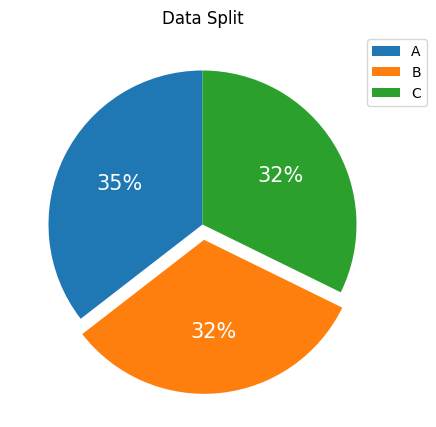

In [5]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [6]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 17.87707


In [7]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(465, 150, 150, 3)

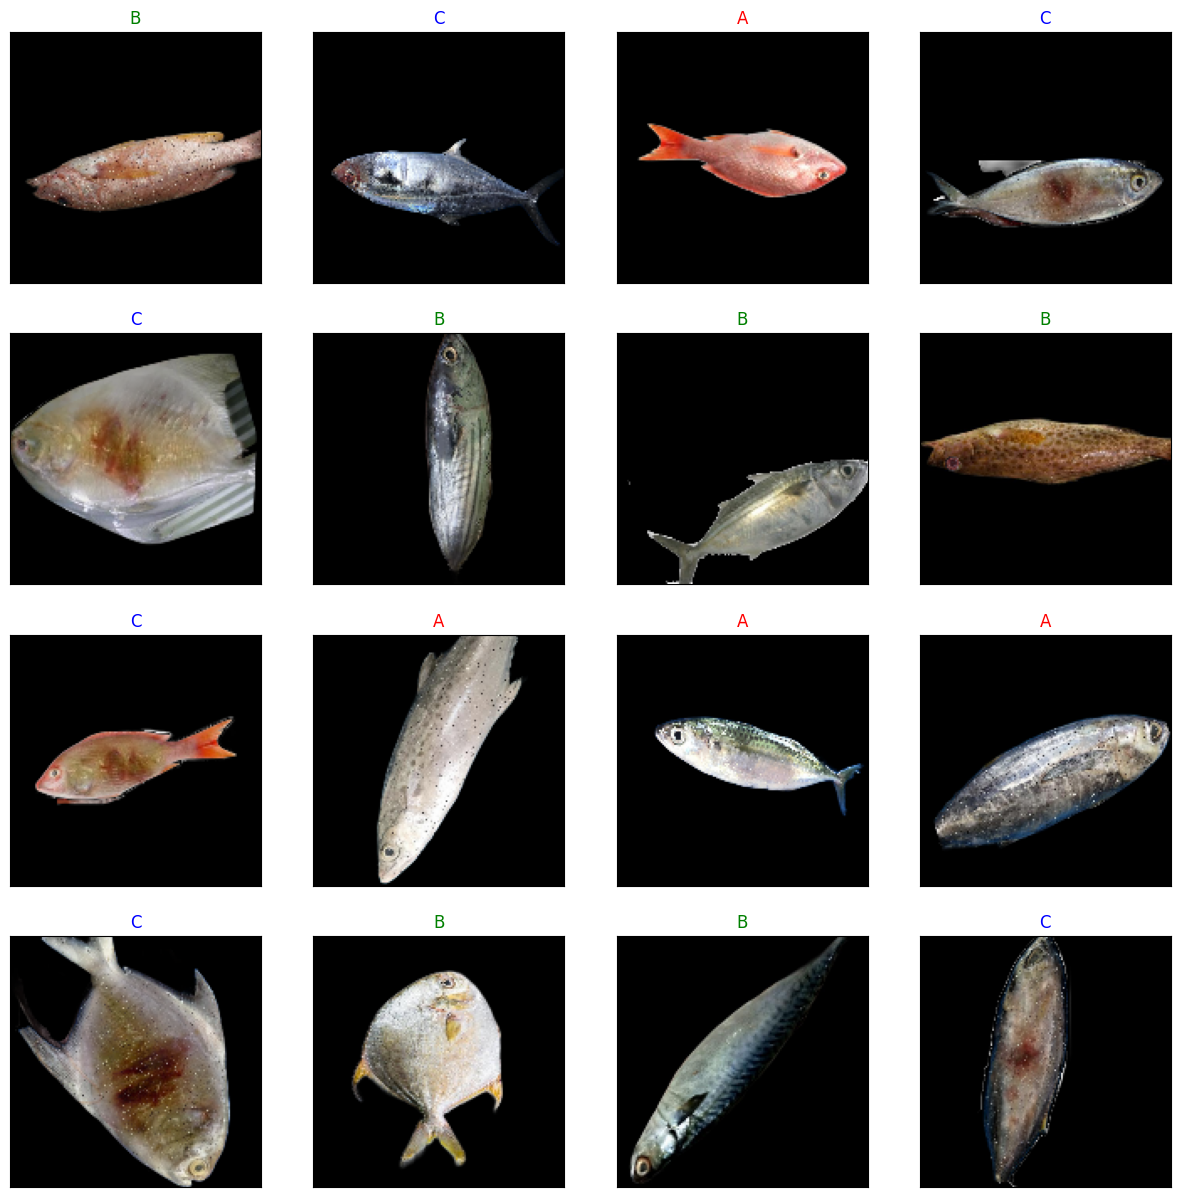

In [8]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [10]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [13]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-tr

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=50,
                                                restore_best_weights=True)


In [16]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
11/11 [==============================] - 7s 280ms/step - loss: 1.4831 - accuracy: 0.4554 - categorical_accuracy: 0.3538 - val_loss: 0.8218 - val_accuracy: 0.6143 - val_categorical_accuracy: 0.1571 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 1s 99ms/step - loss: 0.8931 - accuracy: 0.5785 - categorical_accuracy: 0.3754 - val_loss: 0.7186 - val_accuracy: 0.7214 - val_categorical_accuracy: 0.3571 - lr: 9.0484e-04
Epoch 3/50
11/11 [==============================] - 1s 103ms/step - loss: 0.7900 - accuracy: 0.6431 - categorical_accuracy: 0.3015 - val_loss: 0.6499 - val_accuracy: 0.7429 - val_categorical_accuracy: 0.4429 - lr: 8.1873e-04
Epoch 4/50
11/11 [==============================] - 1s 98ms/step - loss: 0.6712 - accuracy: 0.7323 - categorical_accuracy: 0.4492 - val_loss: 0.5942 - val_accuracy: 0.8143 - val_categorical_accuracy: 0.3500 - lr: 7.4082e-04
Epoch 5/50
11/11 [==============================] - 1s 99ms/step - loss: 0.5836 - accuracy: 0.7354 - categ

5/5 - 0s - loss: 0.3195 - accuracy: 0.8786 - categorical_accuracy: 0.3500 - 279ms/epoch - 56ms/step


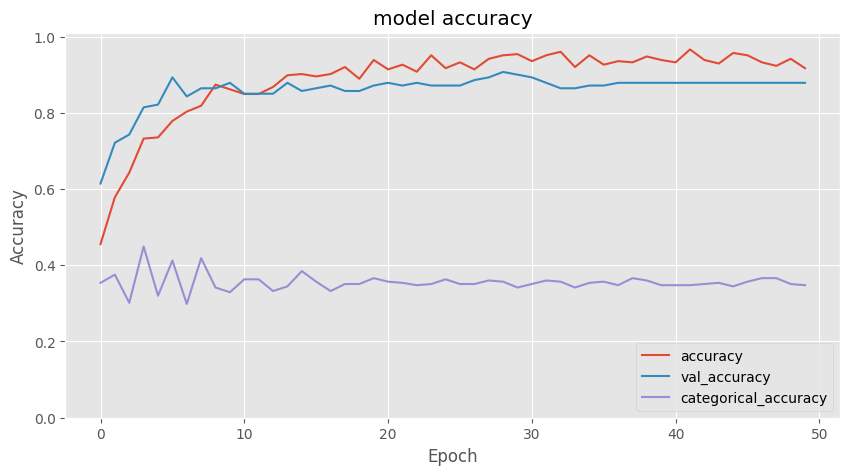

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

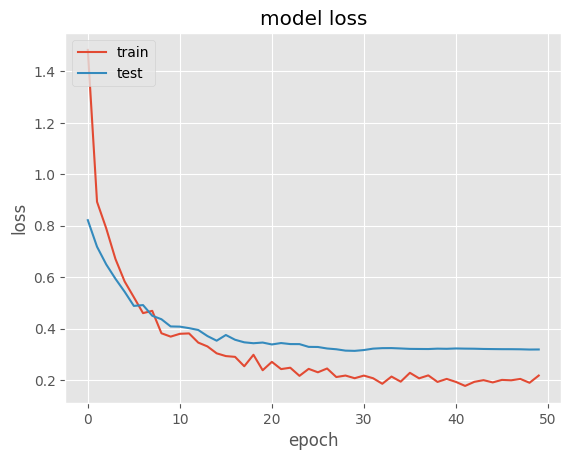

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 577,155
Non-tr

In [21]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
11/11 [==============================] - 6s 197ms/step - loss: 0.4786 - accuracy: 0.8092 - categorical_accuracy: 0.3723 - val_loss: 0.6731 - val_accuracy: 0.7714 - val_categorical_accuracy: 0.5214 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 1s 97ms/step - loss: 0.3297 - accuracy: 0.8892 - categorical_accuracy: 0.3323 - val_loss: 0.3774 - val_accuracy: 0.8571 - val_categorical_accuracy: 0.4429 - lr: 9.0484e-04
Epoch 3/50
11/11 [==============================] - 1s 88ms/step - loss: 0.1755 - accuracy: 0.9385 - categorical_accuracy: 0.3508 - val_loss: 0.4954 - val_accuracy: 0.8143 - val_categorical_accuracy: 0.4643 - lr: 8.1873e-04
Epoch 4/50
11/11 [==============================] - 1s 88ms/step - loss: 0.1469 - accuracy: 0.9415 - categorical_accuracy: 0.3477 - val_loss: 0.4180 - val_accuracy: 0.8571 - val_categorical_accuracy: 0.4000 - lr: 7.4082e-04
Epoch 5/50
11/11 [==============================] - 1s 87ms/step - loss: 0.1494 - accuracy: 0.9477 - catego

5/5 - 0s - loss: 0.3793 - accuracy: 0.9000 - categorical_accuracy: 0.3429 - 285ms/epoch - 57ms/step


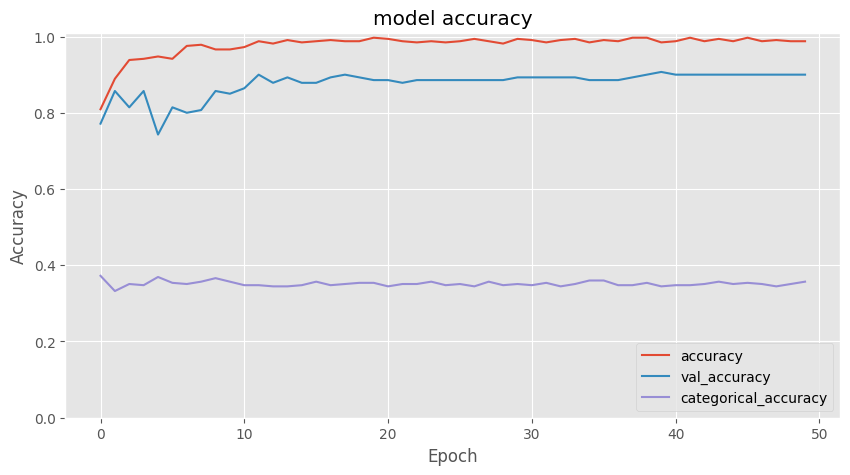

In [22]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

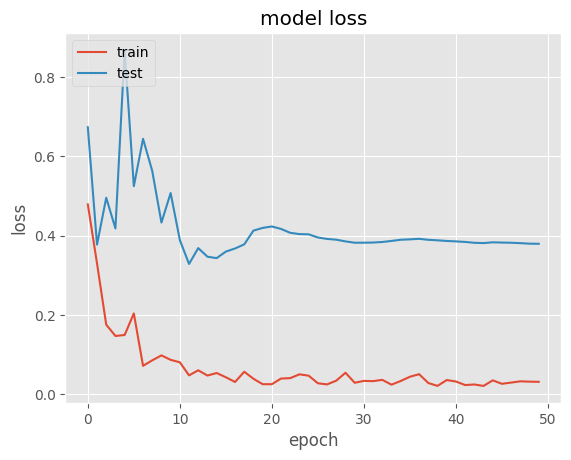

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
result=model.evaluate(train_images, train_labels)

11/11 [==============================] - 1s 55ms/step - loss: 0.0130 - accuracy: 0.9938 - categorical_accuracy: 0.3569


In [25]:
result=model.evaluate(test_images, test_labels)

5/5 [==============================] - 0s 52ms/step - loss: 0.3793 - accuracy: 0.9000 - categorical_accuracy: 0.3429


In [26]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.3793213963508606
accuracy : 0.8999999761581421
categorical_accuracy : 0.34285715222358704


In [27]:
# model.summary()

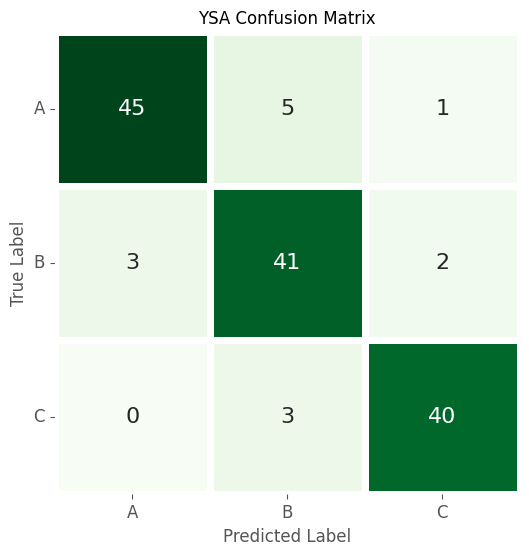

In [28]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [29]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.901489


In [30]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.901297


In [31]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.900827


In [32]:
def Prediction(image):

    global width, height, files, labels

    img = cv2.resize(image,(width,height))

    test = img / 255.0

    pred = model.predict(np.array([image])).argmax()

    return labels.inverse_transform([pred])[0]

In [33]:
def Prediction2(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0
    
    class_list = ['A', 'B', 'C'] 
    
    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

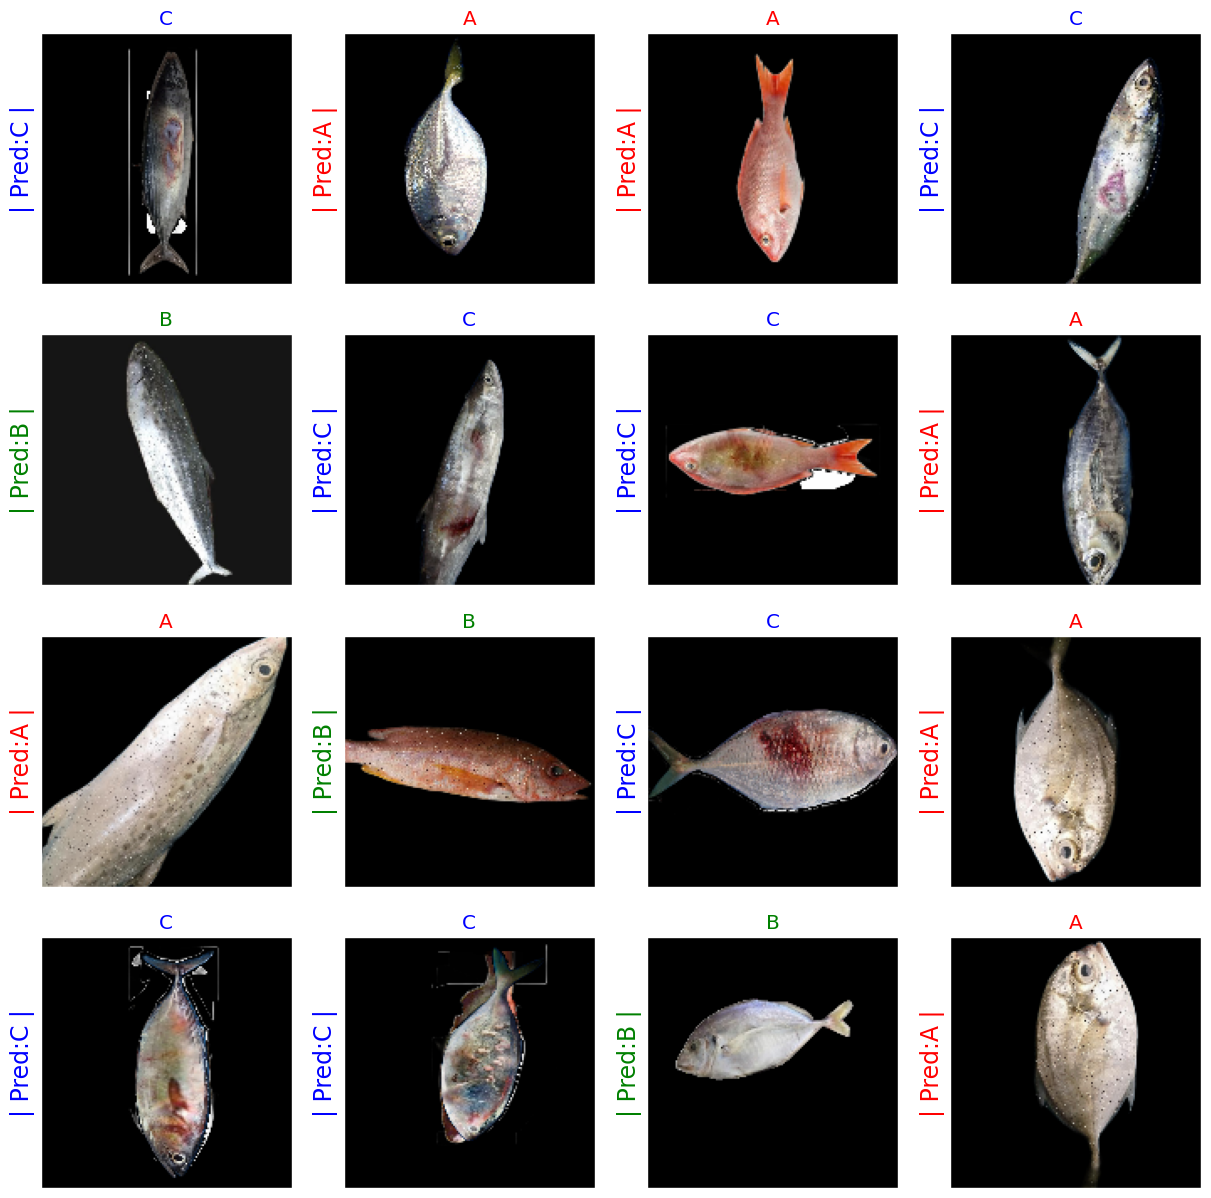

In [34]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction2(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

1.jpg
Prediction range:
Minimum value: 1.7139922e-07
Maximum value: 0.99999905
Grade: A
Good
10.jpg
Prediction range:
Minimum value: 1.5427638e-08
Maximum value: 0.97359574
Grade: C
Bad
100.jpg
Prediction range:
Minimum value: 0.00016322319
Maximum value: 0.91665995
Grade: A
Good
101.jpg
Prediction range:
Minimum value: 0.06643837
Maximum value: 0.82522786
Grade: A
Good
102.jpg
Prediction range:
Minimum value: 0.00040679527
Maximum value: 0.9894153
Grade: A
Good
103.jpg
Prediction range:
Minimum value: 0.00022054481
Maximum value: 0.99612904
Grade: A
Good
104.jpg
Prediction range:
Minimum value: 0.00019987999
Maximum value: 0.97326905
Grade: A
Good
106.jpg
Prediction range:
Minimum value: 0.0012819773
Maximum value: 0.9925432
Grade: A
Good
107.jpg
Prediction range:
Minimum value: 0.0039679077
Maximum value: 0.9521245
Grade: A
Good
108.jpg
Prediction range:
Minimum value: 0.0070160152
Maximum value: 0.9617691
Grade: A
Good
109.jpg
Prediction range:
Minimum value: 0.005519461
Maximum val

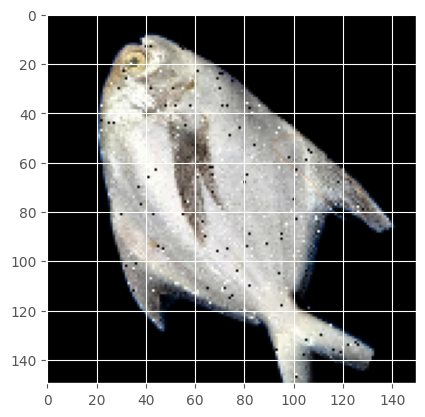

In [35]:
# user_path = r"C:\laragon\www\Project\Bloomy\img\output"
user_path = r"D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\data2\\A"

image_files = os.listdir(user_path)
for idx in range(0, 149):
    index = idx
    image_file = os.path.join(user_path, image_files[index])

    print(image_files[index])
    img = image.load_img(image_file, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 

    classes = model.predict(x, batch_size=1)
    nilai_min = np.min(classes)
    nilai_max = np.max(classes)

    print("Prediction range:")
    print("Minimum value:", nilai_min)
    print("Maximum value:", nilai_max)

    class_list = ['A', 'B', 'C'] 

    predicted_class = class_list[np.argmax(classes[0])]
    print('Grade:', predicted_class)

    if predicted_class == 'A':
        print('Good')
    

    elif predicted_class == 'B':
        print('Medium')


    elif predicted_class == 'C':
        print('Bad')

In [37]:
# file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
# file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'
file_location = 'D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\bloomy-fishgrading/fishgrading_model.h5'

model.save(file_location)